In [29]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
camb_path = os.path.realpath(os.path.join(os.getcwd(), '..'))
print(camb_path)
sys.path.insert(0, camb_path)
import camb
from scipy.optimize import root
from scipy.interpolate import CubicSpline

plt.rcParams['mathtext.default']= 'regular'
plt.rcParams['legend.fontsize'] = 13
plt.rcParams['axes.labelsize'] = 15
plt.rcParams["axes.labelpad"]=10             # axes labels distance from tick labels
plt.rcParams["axes.titlesize"] = 15
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['figure.dpi'] = 150             #  figure dimension in dpi

/data2/code/eftcamb_osc


In [2]:
ede_par = {'num_massive_neutrinos': 1,
            'nnu': 3.044,
            'mnu': 0.06,
            'dark_energy_model': 'EFTCAMB',
            'EFTflag': 4,
            'FullMappingEFTmodel': 0,
            'Horndeski_model': 3,
            'Horndeski_parameter_number': 2,
            'Horndeski_model_specific_ic': True,
            'Horndeski_evolve_hubble': False,
            'EFT_evolve_delta_phi': True,
            'EFT_evolve_metric_h': False,
            'Horndeski_background_interpolation_num_points': 10000,
            'Horndeski_background_a_ini': 1.0e-14,
            'a_pertcutoff_before': 1.0e-05,
            'a_pertcutoff_after': 0.1,
            'EFTCAMB_turn_on_time': 1.0e-10,
            'EFT_skip_stability': True,
            'EFT_ghost_math_stability': False,
            'EFT_mass_math_stability': False,
            'EFT_ghost_stability': False,
            'EFT_gradient_stability': False,
            'EFT_mass_stability': False,
            'EFT_additional_priors': False,
            'lmax': 4000,
        }
lcdm_par = {'num_massive_neutrinos': 1,
            'nnu': 3.044,
            'mnu': 0.06,
            'dark_energy_model': 'ppf',
            'EFTflag': 0,
            'w': -1,
            'lmax': 4000,
            }

In [3]:
def shoot(params, fede, zc, model_par):
    def is_ic(x):
        v0 = x[0]
        phi_i = x[1]
        v_phi = 4.*v0*phi_i*phi_i*phi_i
        xi = model_par/v_phi
        theory.update({'Horndeski_param1': xi, 'Horndeski_param2': v0, 'Honrdeski_phi_ini': phi_i})
        pars = camb.set_params(H0=params['H0'], ombh2=params['ombh2'], omch2=params['omch2'], **theory)
        res = camb.get_background(pars, no_thermo=True)
        rlt = np.empty(2)
        rlt[0] = res.Params.EFTCAMB_parameter_cache.maxfrac_hdsk/fede - 1
        rlt[1] = res.Params.EFTCAMB_parameter_cache.z_maxfrac_hdsk/zc - 1
        return rlt
    theory = ede_par.copy()
    theory.update({'Horndeski_shooting': True,})
    x0 = np.empty(2)
    rho_fid = 1.21e-11*(zc+1)**4 + 4.756e-8*(zc+1)**3
    x0[0] = rho_fid/16/fede
    x0[1] = 2*np.sqrt(fede)
    rlt = root(is_ic, x0, tol=0.1, options={'eps': 0.05})
    v0 = rlt.x[0]
    phi_i = rlt.x[1]
    v_phi = 4.*v0*phi_i*phi_i*phi_i
    xi = model_par/v_phi
    return xi, v0, phi_i

def load_cosmo(file, overwrite={}):
    fin = open(file, 'r')
    nms = fin.readline().replace('#','').split()
    fin.close()
    dat = np.loadtxt(file)
    for par in overwrite.keys():
        if par in nms:
            dat[nms.index(par)] = overwrite[par]
    cosmo_par = {}
    for par in ['ombh2', 'omch2', 'H0', 'ns', 'As', 'tau', 'A_planck']:
        cosmo_par[par] = dat[nms.index(par)]
    if 'f_hede' in nms:
        fede = dat[nms.index('f_hede')]
        zc = np.exp(dat[nms.index('lnzc')])
        xiv_phi = dat[nms.index('xiv_phi')] if 'xiv_phi' in nms else 0
        xi, v0, phi_i = shoot(cosmo_par, fede, zc, xiv_phi)
        cosmo_par.update({'Horndeski_param1': xi, 'Horndeski_param2': v0, 'Honrdeski_phi_ini': phi_i})
    return cosmo_par


In [4]:
hede_bf = load_cosmo('minimum/boxphi_f_mc_p20base.minimum.txt')
hede_bs = load_cosmo('minimum/boxphi_f_mc_p20base.minimum.txt', overwrite={'xiv_phi':0})
hede_ob = load_cosmo('minimum/boxphi_f_mc_p20base.minimum.txt', overwrite={'xiv_phi':0, 'ombh2':0.0228})
ede_bf = load_cosmo('minimum/phi4_f_mc_p20base.minimum.txt')
# lcdm_cosmo = load_cosmo('minimum/lcdm_mc_p20base.minimum.txt')
lcdm_bf = {'ombh2':0.2238280E-01, 'omch2':0.1201075E+00, 'H0':0.6732117E+02, 'ns':0.9660499E+00, 'As':2.100549e-9, 'tau':0.5430842E-01, 'A_planck':0.1000442E+01}

In [5]:
tmp = lcdm_bf.copy()
cal2 = tmp.pop('A_planck')**2
tmp.update(lcdm_par)
pars = camb.set_params(**tmp)
rlts = camb.get_results(pars)
cl_ref = rlts.get_cmb_power_spectra(pars, CMB_unit='muK')['total']

tmp = hede_bf.copy()
cal2 = tmp.pop('A_planck')**2
tmp.update(ede_par)
pars = camb.set_params(**tmp)
rlts = camb.get_results(pars)
theta = rlts.cosmomc_theta()
cl_mg = rlts.get_cmb_power_spectra(pars, CMB_unit='muK')['total']

tmp = hede_bs.copy()
cal2 = tmp.pop('A_planck')**2
tmp.update(ede_par)
pars = camb.set_params(**tmp)
# pars.set_H0_for_theta(theta)
rlts = camb.get_results(pars)
cl_base = rlts.get_cmb_power_spectra(pars, CMB_unit='muK')['total']

tmp = hede_ob.copy()
cal2 = tmp.pop('A_planck')**2
tmp.update(ede_par)
pars = camb.set_params(**tmp)
# pars.set_H0_for_theta(theta)
cl_ob = rlts.get_cmb_power_spectra(pars, CMB_unit='muK')['total']

/data2/VSCode-linux-x64/data/tmp/ipykernel_3148088/1428441298.py:2: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(hspace=0)
/data2/VSCode-linux-x64/data/tmp/ipykernel_3148088/1428441298.py:11: RuntimeWarning: invalid value encountered in divide
  ax[0].plot(ell, cl_base[:,0]/cl_ref1[:,0]-1, label='Base')
/data2/VSCode-linux-x64/data/tmp/ipykernel_3148088/1428441298.py:12: RuntimeWarning: invalid value encountered in divide
  ax[0].plot(ell, cl_mg[:,0]/cl_ref1[:,0]-1, label=r'$+\xi$')
/data2/VSCode-linux-x64/data/tmp/ipykernel_3148088/1428441298.py:13: RuntimeWarning: invalid value encountered in divide
  ax[0].plot(ell, cl_ob[:,0]/cl_ref1[:,0]-1, label='$+\omega_b$')
/data2/VSCode-linux-x64/data/tmp/ipykernel_3148088/1428441298.py:27: RuntimeWarning: invalid value encountered in divide
  ax[1].plot(ell, cl_base[:,1]/cl_ref1[:,1]-1, label='Base')
/data2/VSCode-linux-x64

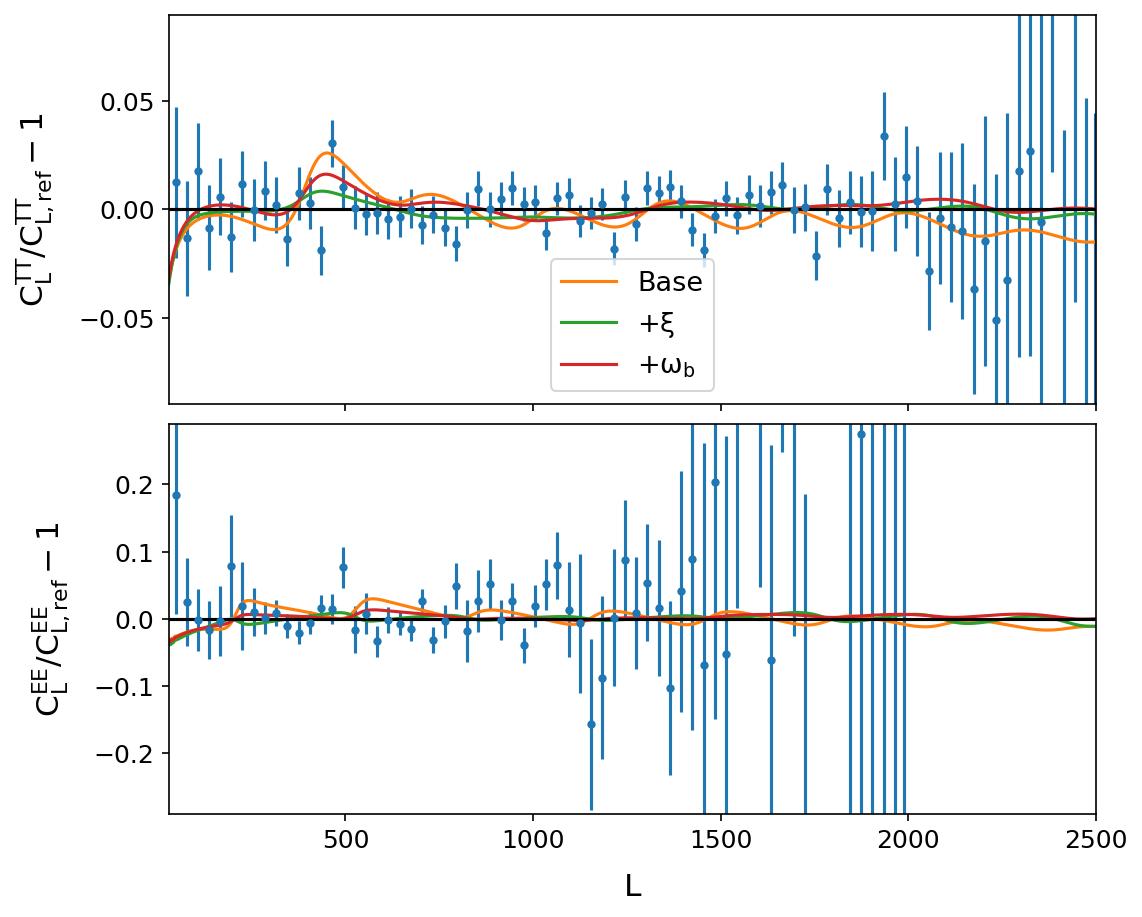

In [34]:
fig, ax = plt.subplots(2,1, figsize = (7.5,6), sharex=True, layout="constrained")
fig.subplots_adjust(hspace=0)

dat = np.loadtxt('/data2/data/planck_2018/COM_PowerSpect_CMB-TT-binned_R3.01.txt')
ax[0].errorbar(dat[:,0], dat[:,1]/dat[:,4]-1, yerr=dat[:,2]/dat[:,4], fmt='.')

cl_ref1 = cl_ref/1.006

ell = np.arange(cl_ref.shape[0])
# lwd = np.arange(15,2600)
ax[0].plot(ell, cl_base[:,0]/cl_ref1[:,0]-1, label='Base')
ax[0].plot(ell, cl_mg[:,0]/cl_ref1[:,0]-1, label=r'$+\xi$')
ax[0].plot(ell, cl_ob[:,0]/cl_ref1[:,0]-1, label='$+\omega_b$')
ax[0].axhline(0, c='black')
# plt.yscale('log')
# plt.xscale('log')
# ax[0].set_xlim([30,3000])
ax[0].set_ylim(-0.09,0.09)
# ax[0,0].set_xlabel('L')
ax[0].set_ylabel(r'$C_L^{TT}/C^{TT}_{L,\rm{ref}}-1$')
ax[0].legend(loc='lower center')

dat = np.loadtxt('/data2/data/planck_2018/COM_PowerSpect_CMB-EE-binned_R3.02.txt')
ax[1].errorbar(dat[:,0], dat[:,1]/dat[:,4]-1, yerr=dat[:,2]/dat[:,4], fmt='.')

ell = np.arange(cl_ref.shape[0])
ax[1].plot(ell, cl_base[:,1]/cl_ref1[:,1]-1, label='Base')
ax[1].plot(ell, cl_mg[:,1]/cl_ref1[:,1]-1, label=r'$+\xi$')
ax[1].plot(ell, cl_ob[:,1]/cl_ref1[:,1]-1, label=r'$+\omega_b$')
ax[1].axhline(0, c='black')
# plt.yscale('log')
# plt.xscale('log')
ax[1].set_xlim([30,2500])
ax[1].set_ylim(-0.29,0.29)
ax[1].set_xlabel('L')
ax[1].set_ylabel(r'$C_L^{EE}/C^{EE}_{L,\rm{ref}}-1$')
# ax[1].legend()

# plt.tight_layout()
# plt.savefig('ttee.pdf')

In [8]:
k_num = 100
k_s = np.logspace(-3, -0.7, num=k_num)
a_num = 1000
a_s = np.logspace(-4.5, -1, num=a_num)
z_s = 1/a_s-1

# tmp = lcdm_cosmo.copy()
# cal2 = tmp.pop('A_planck')**2
# tmp.update(lcdm_par)
# pars = camb.set_params(**tmp)
# rlts = camb.get_results(pars)
# nms_ref, vls = pars.EFTCAMB.get_evolution(rlts, ks, a_s)
# pt_ref = np.empty([len(ks), len(nms_ref), len(a_s)])
# for j in range(len(ks)):
#     for i in range(len(a_s)):
#         pt_ref[j,:,i] = np.array(list(vls[j][i]))

tmp = hede_bf.copy()
cal2 = tmp.pop('A_planck')**2
tmp.update(ede_par)
pars = camb.set_params(**tmp)
rlts = camb.get_results(pars)
nms_mg, vls = pars.EFTCAMB.get_scale_evolution(rlts, k_s, a_s)
pt_mg = np.empty([k_num, len(nms_mg), a_num])
for j in range(k_num):
    for i in range(a_num):
        pt_mg[j,:,i] = np.array(list(vls[j][i]))
rhov_mg = 0.5*(pt_mg[0,nms_mg.index('dphi'),:]/pt_mg[0,nms_mg.index('a'),:])**2 + tmp['Horndeski_param2']*pt_mg[0,nms_mg.index('phi_scf'),:]**4
H_mg = pt_mg[0,nms_mg.index('adotoa'),:]/pt_mg[0,nms_mg.index('a'),:]

tmp = hede_bs.copy()
cal2 = tmp.pop('A_planck')**2
tmp.update(ede_par)
pars = camb.set_params(**tmp)
rlts = camb.get_results(pars)
nms_base, vls = pars.EFTCAMB.get_scale_evolution(rlts, k_s, a_s)
pt_base = np.empty([k_num, len(nms_base), len(a_s)])
for j in range(k_num):
    for i in range(a_num):
        pt_base[j,:,i] = np.array(list(vls[j][i]))
rhov_base = 0.5*(pt_base[0,nms_base.index('dphi'),:]/pt_base[0,nms_base.index('a'),:])**2 + tmp['Horndeski_param2']*pt_base[0,nms_base.index('phi_scf'),:]**4
H_base = pt_base[0,nms_base.index('adotoa'),:]/pt_base[0,nms_base.index('a'),:]

# tmp = hede_cosmo.copy()
# cal2 = tmp.pop('A_planck')**2
# # tmp['Horndeski_param1'] = 0
# tmp['ombh2'] = 0.0228
# tmp.update(ede_par)
# pars = camb.set_params(**tmp)
# rlts = camb.get_results(pars)
# nms_ob, vls = pars.EFTCAMB.get_evolution(rlts, k, a_s)
# pt_ob = np.empty([len(a_s), len(nms_ref)])
# for i in range(len(a_s)):
#     pt_ob[i,:] = np.array(list(vls[0][i]))

/data2/VSCode-linux-x64/data/tmp/ipykernel_3148088/2876930514.py:11: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(hspace=0)


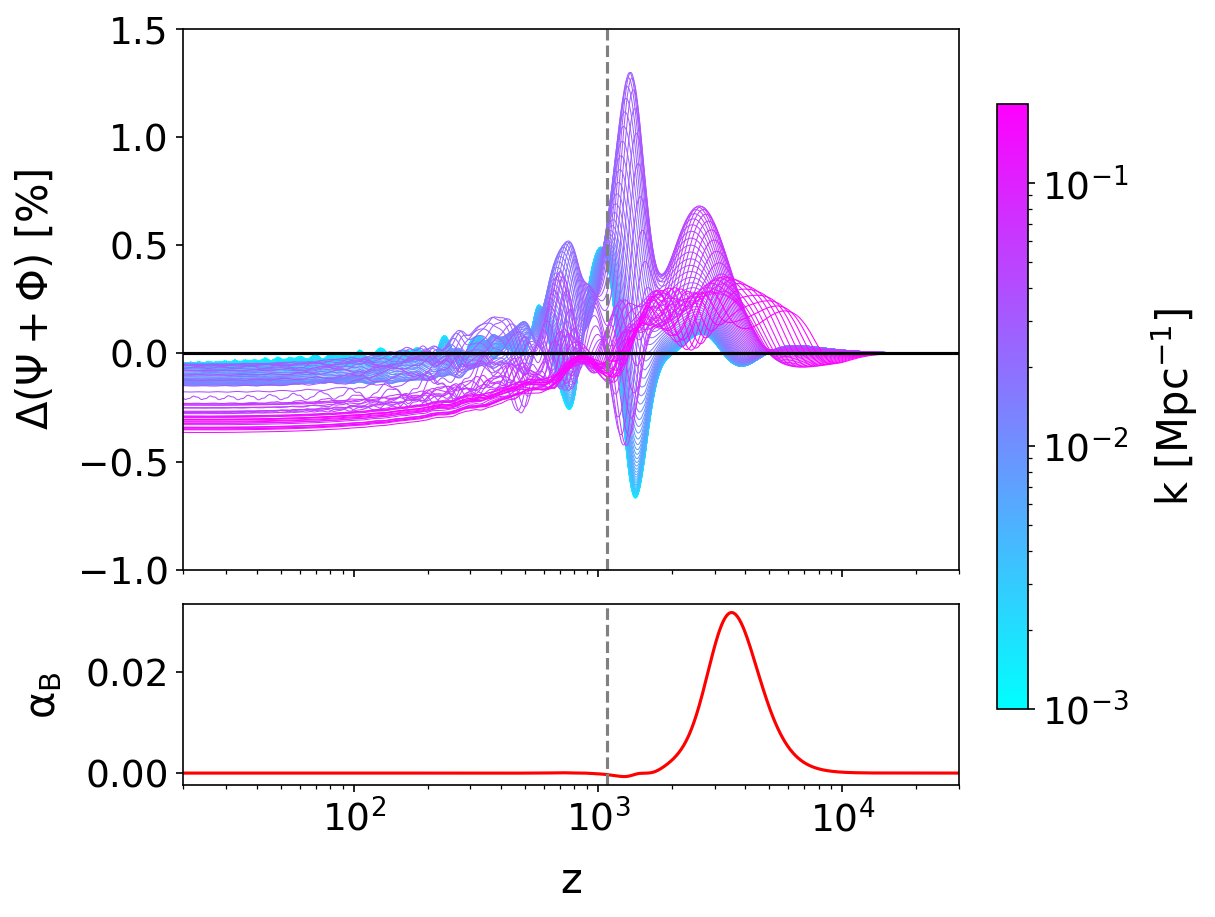

In [25]:
import matplotlib as mpl

plt.rcParams['legend.fontsize'] = 18
plt.rcParams['axes.labelsize'] = 20
plt.rcParams["axes.labelpad"]=10             # axes labels distance from tick labels
plt.rcParams["axes.titlesize"] = 22
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18

fig, ax = plt.subplots(2,1, figsize = (8,6), sharex=True, height_ratios=[3,1], layout="constrained")
fig.subplots_adjust(hspace=0)

cmap = mpl.cm.cool
norm = mpl.colors.LogNorm(vmin=k_s[0], vmax=k_s[-1])

for i, k in enumerate(k_s):
  weyl_mg = pt_mg[i,nms_mg.index('Psi'),:] + pt_mg[i,nms_mg.index('Phi'),:]
  weyl_base = pt_base[i,nms_base.index('Psi'),:] + pt_base[i,nms_base.index('Phi'),:]
  ax[0].plot(z_s, 100*weyl_mg/weyl_base-100, c=cmap(norm(k)),lw=0.5)
ax[0].axvline(1088, ls='--', c='gray')
ax[0].axhline(0, lw=1.5, c='black')
# ax[0].set_ylabel(r'$\Psi_{\rm{MG}}/\Psi_{\rm{Ref}}-1$')
ax[0].set_ylabel(r'$\Delta(\Psi+\Phi) \ [\%]$', fontsize=20)
ax[0].set_ylim(-1,1.5)
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax[:], orientation='vertical', label=r'$k \ [\rm{Mpc}^{-1}]$', shrink=0.8)
ax[1].plot(z_s, pt_mg[0,nms_mg.index('alphaB'),:], color='red')
ax[1].axvline(1088, ls='--', c='gray')
# ax[1].plot(1/pt_mg[0,nms_mg.index('a'),:]-1, 10*(pt_mg[-1,nms_mg.index('QS_mu'),:]-1))
ax[1].set_ylabel(r'$\alpha_B$')
# plt.legend()
ax[1].set_xscale('log')
ax[1].set_xlabel(r'$z$')
ax[1].set_xlim(2e1,3e4)
# ax[2].set_ylabel(r'$\mu$')
# plt.ylim(-0.1,0.1)
# plt.savefig('pt.pdf')

/data2/VSCode-linux-x64/data/tmp/ipykernel_3148088/3622177673.py:2: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(hspace=0)


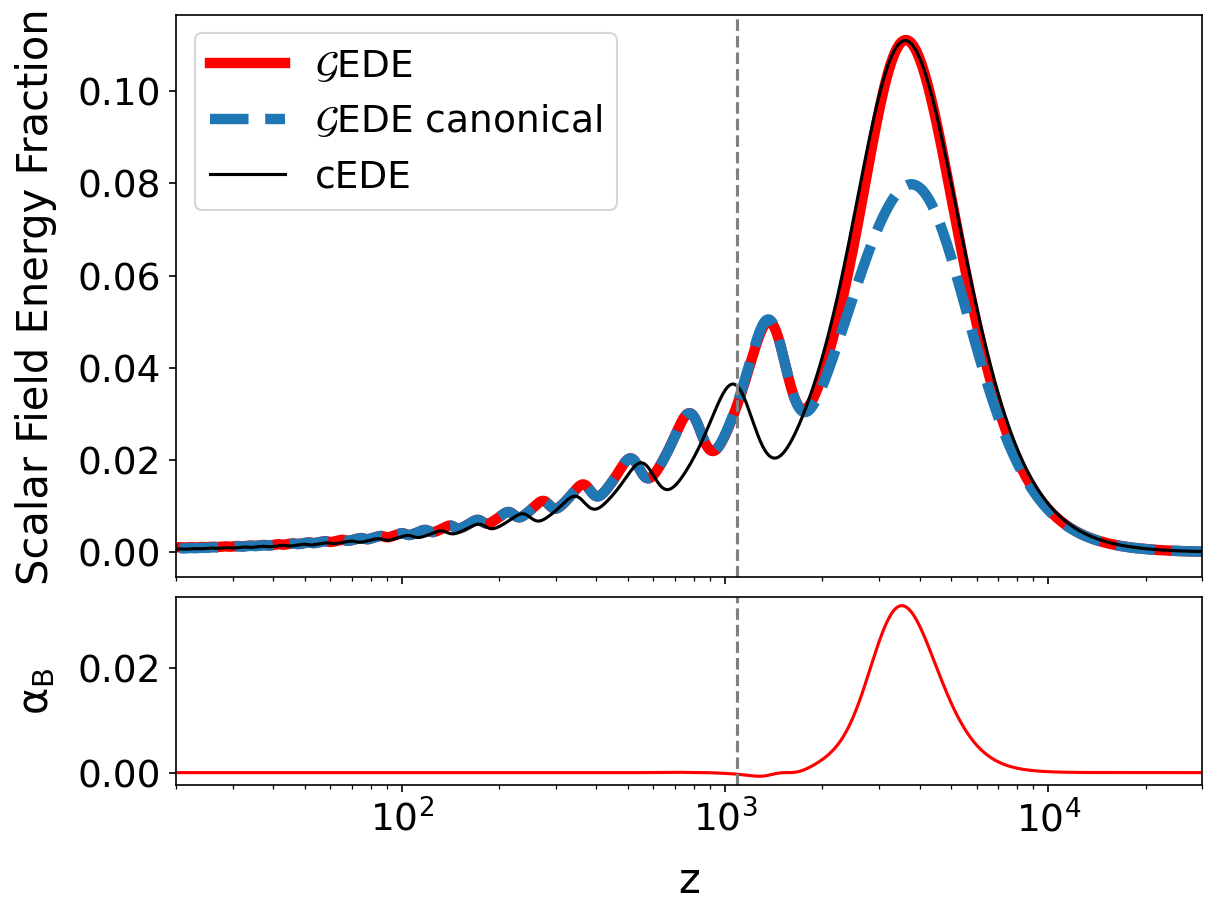

In [28]:
fig, ax = plt.subplots(2,1, figsize = (8,6), sharex=True, height_ratios=[3,1], layout="constrained")
fig.subplots_adjust(hspace=0)

ax[0].plot(z_s, 1 - (pt_mg[i,nms_mg.index('grhoc_t'),:]+pt_mg[i,nms_mg.index('grhor_t'),:]+pt_mg[i,nms_mg.index('grhog_t'),:]+pt_mg[i,nms_mg.index('grhob_t'),:]+pt_mg[i,nms_mg.index('grhonu_tot'),:])*(1+z_s)**2/3/H_mg**2,label=r'$\mathcal{G}$EDE', lw=5, color='red')
ax[0].plot(z_s, rhov_mg/3/H_mg**2,label=r'$\mathcal{G}$EDE canonical', ls='--', lw=5)
ax[0].plot(z_s, rhov_base/3/H_base**2,label='cEDE', c='black')
ax[0].axvline(1088, ls='--', c='gray')
ax[0].legend()
ax[0].set_ylabel('Scalar Field Energy Fraction')
ax[1].plot(z_s, pt_mg[0,nms_mg.index('alphaB'),:], color='red')
ax[1].axvline(1088, ls='--', c='gray')
ax[1].set_xscale('log')
ax[1].set_xlim(2e1,3e4)
ax[1].set_ylabel(r'$\alpha_B$')
ax[1].set_xlabel(r'$z$')

# plt.savefig('bk.pdf')